In [33]:
!pip -q install timesfm

In [34]:
import timesfm

In [38]:
# Prepare the Dataset
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/kboroz/TimeSeriesPrediction/refs/heads/main/Data/Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'])

In [39]:
data['DATE']=pd.to_datetime(data['DATE'])
data.head()

,DATE,Value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


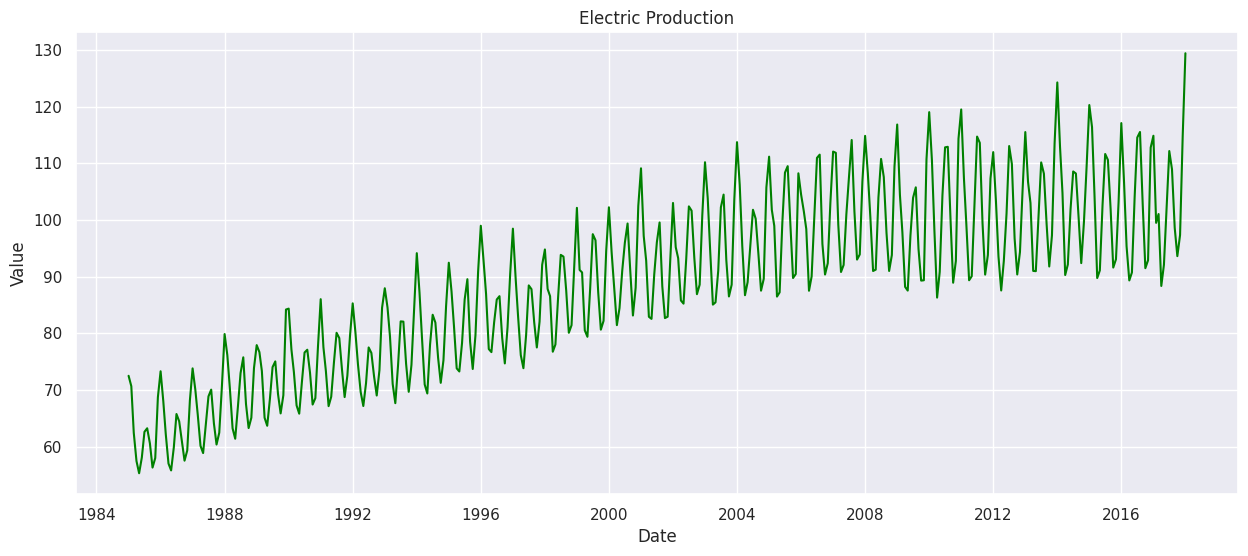

In [40]:
#Let's Visualise the Datas
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # Settings the warnings to be ignored
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x="DATE", y='Value', data=data, color='green')
plt.title('Electric Production')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

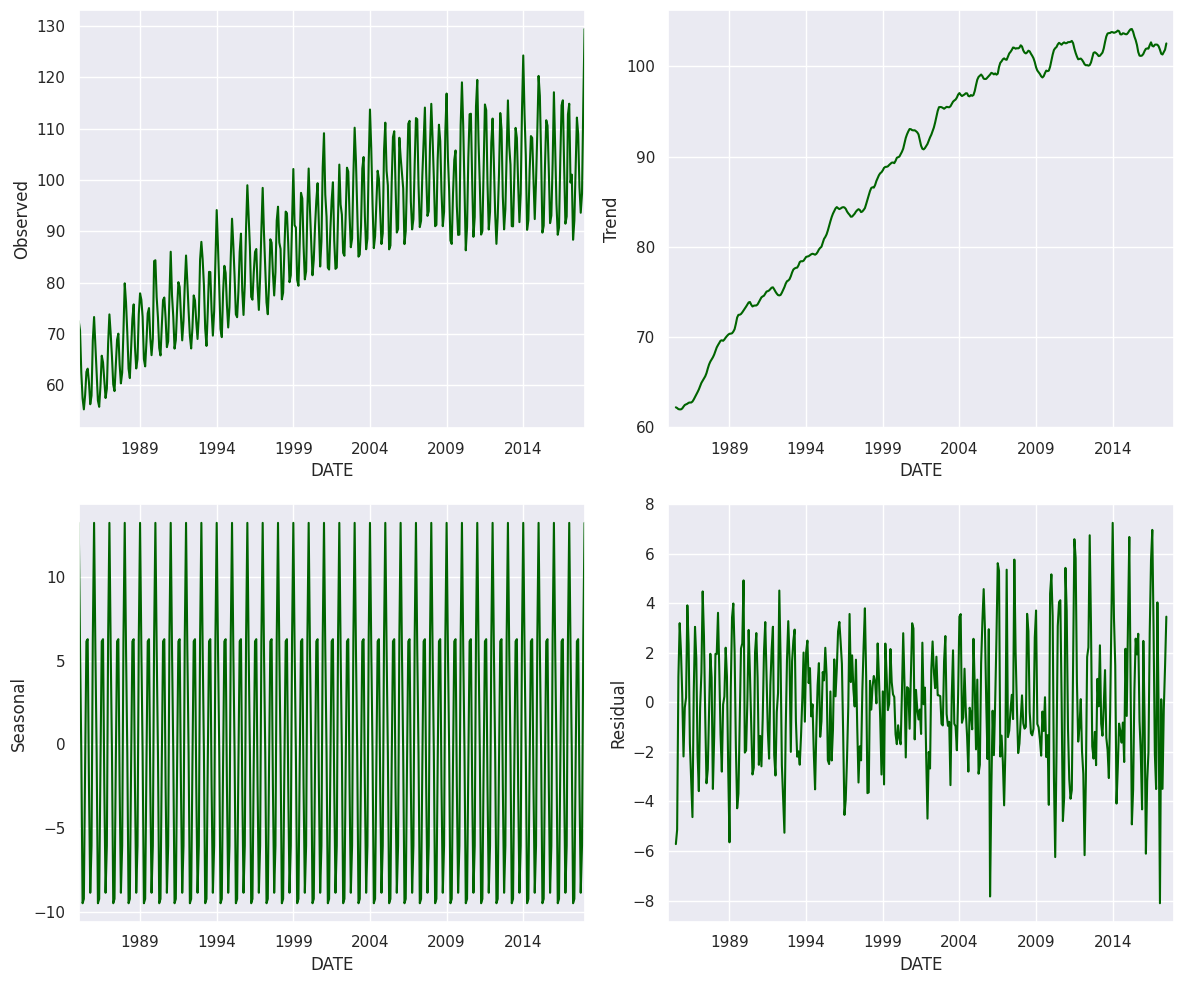

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# Set index to DATE and decompose the data
data.set_index("DATE", inplace=True)
result = seasonal_decompose(data['Value'])
# Create a 2x2 grid for the subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
result.observed.plot(ax=ax1, color='darkgreen')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, color='darkgreen')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, color='darkgreen')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, color='darkgreen')
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()
# Adjust layout and show the plots
plt.tight_layout()
plt.show()
# Reset the index after plotting
data.reset_index(inplace=True)

In [42]:
df = pd.DataFrame({'unique_id':[1]*len(data),'ds': data["DATE"],
"y":data['Value']})


# Ensure the correct column names
df = pd.DataFrame({'unique_id': [1] * len(data), 'ds': data["DATE"], 'Value': data['Value']})

# Splitting into 94% and 6%
split_idx = int(len(df) * 0.94)
# Split the dataframe into train and test sets
train_df = df[:split_idx]
test_df = df[split_idx:]
print(train_df.shape, test_df.shape)

In [61]:
# Load TimesFM pretrained checkpoints with hyperparameters
tfm = timesfm.TimesFm(
  hparams = timesfm.TimesFmHparams(
    context_len=512, # max 512, can be shorter
    horizon_len=128,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu", # ‘gpu’ when using GPU backend for fine-tuning
  ),
  checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
  )
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: Error(s) in loading state_dict for PatchedTimeSeriesDecoder:
	size mismatch for horizon_ff_layer.output_layer.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([240, 1280]).
	size mismatch for horizon_ff_layer.output_layer.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for horizon_ff_layer.residual_layer.weight: copying a param with shape torch.Size([1280, 1280]) from checkpoint, the shape in current model is torch.Size([240, 1280]).
	size mismatch for horizon_ff_layer.residual_layer.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([240]).

In [64]:
# Generate forecasts using the TimesFM model on the given DataFrame
timesfm_forecast = tfm.forecast_on_df(
    inputs=train_df,           # Input DataFrame containing the time-series data for training
    freq="D",                  # Frequency of the time-series data (e.g., 'M' for monthly, 'D' for daily)
    value_name="Value",        # Name of the column containing the values to be forecasted
    num_jobs=-1,               # Number of parallel jobs to use for forecasting (-1 uses all available cores)
)

print(timesfm_forecast)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
     unique_id         ds     timesfm  timesfm-q-0.1  timesfm-q-0.2  \
0            1 2016-01-02  114.003372     111.310463     112.387939   
1            1 2016-01-03  103.136070     100.147095     101.273926   
2            1 2016-01-04   91.904747      88.233047      89.562241   
3            1 2016-01-05   93.013588      89.294357      90.656334   
4            1 2016-01-06  104.382248     100.845985     101.956665   
..         ...        ...         ...            ...            ...   
123          1 2016-05-04   94.402016      79.402939      85.407578   
124          1 2016-05-05  106.926941      91.980705      97.869003   
125          1 2016-05-06  117.839951     103.020226     108.763107   
126          1 2016-05-07  114.795944      99.692963     105.646706   
127          1 2016-05-08  102.715286      87.946419      93.630295   

     timesfm-q-0.3  timesfm-q-0.4  timesfm-q-

In [65]:
timesfm_forecast.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2016-01-02,114.003372,111.310463,112.387939,112.939133,113.265450,114.003372,114.425758,114.956459,115.599701,116.683929
1,1,2016-01-03,103.136070,100.147095,101.273926,102.088531,102.770699,103.136070,103.835594,104.609451,105.363480,106.823021
2,1,2016-01-04,91.904747,88.233047,89.562241,90.338646,91.251541,91.904747,92.574249,93.297508,94.261772,95.993820
3,1,2016-01-05,93.013588,89.294357,90.656334,91.479874,92.111221,93.013588,93.696747,94.618393,95.642426,97.320778
4,1,2016-01-06,104.382248,100.845985,101.956665,102.876053,103.611328,104.382248,105.017845,105.958801,106.721237,108.350311


In [66]:
test_df.head()

,unique_id,ds,Value
373,1,2016-02-01,106.6688
374,1,2016-03-01,95.3548
375,1,2016-04-01,89.3254
376,1,2016-05-01,90.7369
377,1,2016-06-01,104.0375


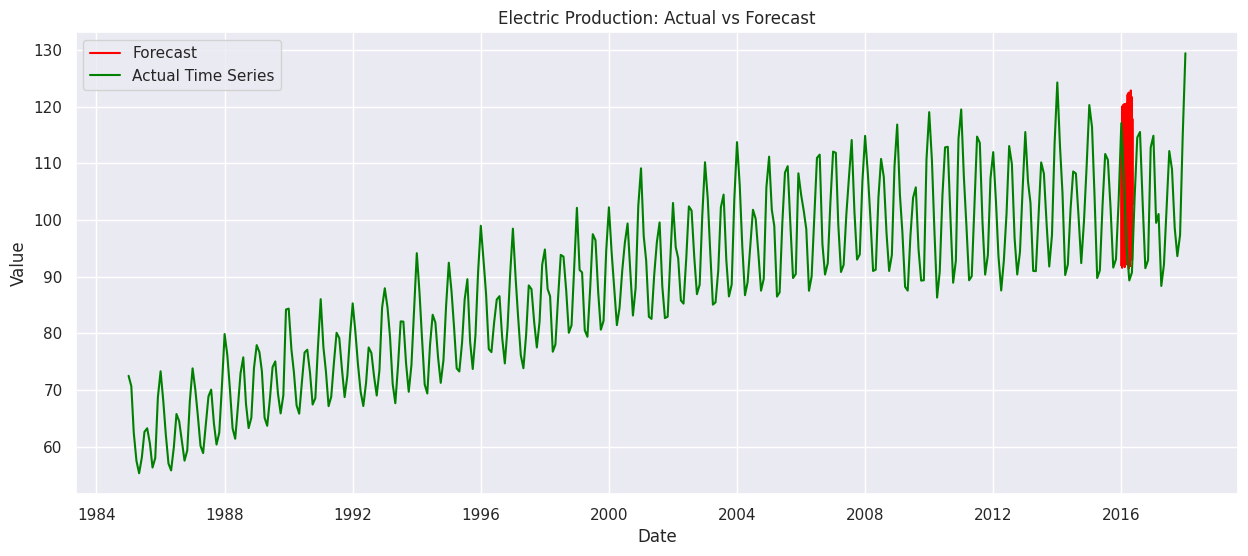

In [67]:
# Let's Visualise the Data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # Setting the warnings to be ignored
# Set the style for seaborn
sns.set(style="darkgrid")
# Plot size
plt.figure(figsize=(15, 6))
# Plot actual timeseries data
sns.lineplot(x="ds", y='timesfm', data=timesfm_forecast, color='red', label='Forecast')
# Plot forecasted values
sns.lineplot(x="DATE", y='Value', data=data, color='green', label='Actual Time Series')
# Set plot title and labels
plt.title('Electric Production: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
# Show the legend
plt.legend()
# Display the plot
plt.show()